In [2]:
%%capture --no-stderr
%pip install -U tiktoken langchain_community tiktoken langchainhub scikit-learn langchain langgraph tavily-python  nomic[local] langchain-nomic langchain_openai

In [2]:
%pip install --upgrade --quiet langchain-community unstructured openpyxl sentence-transformers langchain-ollama langchain_mistralai langgraph rouge_score chromadb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.2 which is incompatible.
jupyterlab 4.3.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires kubernetes<27,>=8.0.0, but you have kubernetes 31.0.0 which is incompatible.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which

### Hyper Parameter Tuning 

In [18]:
# -------------------------------
# Text Splitter Hyperparameters
# -------------------------------
CHUNK_SIZE = 400           # Size of each text chunk (e.g., 250, 400, 500)
CHUNK_OVERLAP = 50         # Overlap between chunks (e.g., 0, 50, 100)

# Embedding Model Hyperparameters
# -------------------------------
EMBEDDING_MODEL_NAME = "all-MiniLM-L6-v2"  # Options: "all-MiniLM-L6-v2", "all-mpnet-base-v2"



os.environ["TAVILY_API_KEY"] = "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"
#CHROMA RETRIEVED DOCUMENTS
retrieved_documents = 4 

#WEB RETRIEVED DOCUMENTS
WEB_RETREIVER_DOCUMENTS = 4

#api key 
API_KEY = "QsVtSj8rL1TZVL0l2usBvNPk0dF7bOMZ"
# LLM Hyperparameters
# -------------------------------
LLM_MODEL_NAME = "mistral-large-latest"  # LLM model to use
LLM_TEMPERATURE = 0.7                    # Sampling temperature (e.g., 0.0 to 1.0)
LLM_TOP_P = 0.9                          # Nucleus sampling (e.g., 0.1 to 1.0)
LLM_FREQUENCY_PENALTY = 0.5              # Frequency penalty (e.g., 0 to 1.0)
LLM_PRESENCE_PENALTY = 0.5      


Sample per class:
                                                    food  Caloric Value  \
Nutrition Density                                                         
1.025                                    chum salmon raw              3   
1.788                                       crayfish raw              3   
2.732                                    scallops cooked             11   
3.100              hand breaded chicken tenders carls jr             57   
3.417                                        scallop raw             10   
...                                                  ...            ...   
1020.882                                   salmon canned            520   
1070.600                                provolone cheese            463   
1095.700                                  gjetost cheese           1058   
1128.200                      mozzarella cheese fat free            159   
1337.000                                  mexican cheese            316   

      

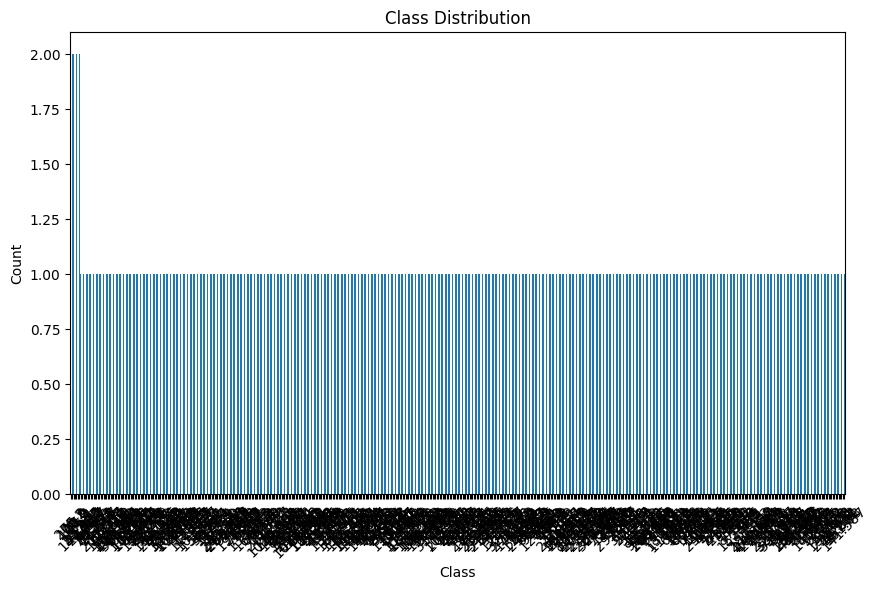

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from langchain.document_loaders import CSVLoader
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
#API KEY
import os

# Step 1: Load CSV and Remove First Two Columns
csv_file_path = "/kaggle/input/public-dataset3/FOOD-DATA-GROUP1.csv"

# Load CSV with pandas and drop the first two columns
df = pd.read_csv(csv_file_path)
df = df.iloc[:, 2:]

# Save the modified DataFrame to a temporary file
with tempfile.NamedTemporaryFile(mode='w', suffix=".csv", delete=False) as temp_csv:
    temp_file_path = temp_csv.name
    df.to_csv(temp_file_path, index=False)

# Load the CSV data into documents using CSVLoader
csv_loader = CSVLoader(file_path=temp_file_path)
docs = csv_loader.load()

# Clean up the temporary file
os.remove(temp_file_path)

# Step 2: Data Visualization
# Display one sample for each class
sample_per_class = df.groupby(df.columns[-1]).first()
print("Sample per class:")
print(sample_per_class)

# Plot class distribution
plt.figure(figsize=(10, 6))
df[df.columns[-1]].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Step 3: Text Splitting
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs)

# Step 4: Initialize Embedding Model
embed = SentenceTransformerEmbeddings(model_name=EMBEDDING_MODEL_NAME)

# Step 5: Initialize Chroma Vector Store
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embed,
    persist_directory="/kaggle/working/"  # Adjust save path if necessary
)

# Add documents to the vector store
vector_store.add_documents(doc_splits)

# Step 6: Retrieve Documents (Optional)
retriever = vector_store.as_retriever(k=retrieved_documents)



In [20]:
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7acfdb5ca7d0>, search_kwargs={})

In [21]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_mistralai import ChatMistralAI



llm = ChatMistralAI(
    model=LLM_MODEL_NAME,
    temperature=LLM_TEMPERATURE,
    api_key = API_KEY
)

prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)


retrieval_grader = prompt | llm | JsonOutputParser()
#question = "queen crab raw caloric value"
#docs = retriever.invoke(question)
#doc_txt = docs[1].page_content
#print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))
#doc_txt

In [22]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)



# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
#generation = rag_chain.invoke({"documents": docs, "question": question})
#print(generation)
#print(docs)

In [23]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=WEB_RETREIVER_DOCUMENTS)

## Create the Graph 

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

In [26]:
import time
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    # Simulating LLM call with delay
    time.sleep(3)  # Adding 2 second delay
    documents = retriever.invoke(question)
    time.sleep(3)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    question = state["question"]
    documents = state["documents"]
    time.sleep(3)
    generation = rag_chain.invoke({"documents": documents, "question": question})
    time.sleep(3)
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    # Simulating LLM call with delay
    for d in documents:
        time.sleep(3)
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        time.sleep(3)
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    time.sleep(3)
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()



In [37]:
import uuid


def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    time.sleep(4)
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "what is the amount of Fat in  food 'cream cheese low fat?'"}
response = predict_custom_agent_local_answer(example)



In [38]:
print(response["response"])

The amount of fat in 'cream cheese low fat' is 2.3 grams.


### Rogue And Blue Scores and plots 

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import json



# Example of test data (questions and expected answers)
test_data = [
    {"question": "What is the amount of Fat in food 'cream cheese low fat?'", "expected_answer": "Low-fat cream cheese contains 2.3g of fat per serving."},
    {"question": "What is the caloric value of the food tahini?",             "expected_answer": "Caloric Value of tahini contains 86."},
    {"question": "What is the amount of sugars in cheese spread?",            "expected_answer": "Cheese spread has 8.4 sugar value."},
    {"question": "What is the amount of Polyunsaturated fats in chicken dumplings soup?", "expected_answer": "Chicken dumplings soup has 3.2g polyunsatruated fats."},
    {"question": "How many Carbohydrates are in orange marmalade?", "expected_answer": "orange marmalade has 13.3g Carbohydrates."}
]



bleu_scores, rouge_scores = [], []


# Function to evaluate BLEU score
def calculate_bleu_score(predicted_answer, expected_answer):
    predicted_tokens = predicted_answer.split()
    expected_tokens = expected_answer.split()
    return sentence_bleu([expected_tokens], predicted_tokens)

# Function to evaluate ROUGE score
def calculate_rouge_score(predicted_answer, expected_answer):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(expected_answer, predicted_answer)
    return scores

# Function to evaluate precision, recall, and F1 score
def calculate_precision_recall_f1(predicted_answer, expected_answer):
    predicted_words = set(predicted_answer.split())
    expected_words = set(expected_answer.split())
    
    precision = len(predicted_words & expected_words) / len(predicted_words) if predicted_words else 0
    recall = len(predicted_words & expected_words) / len(expected_words) if expected_words else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return precision, recall, f1



In [65]:
# Function to run evaluation
def evaluate_rag_model(test_data):
    total_bleu_score = 0
    total_rouge1_score = 0
    total_rouge2_score = 0
    total_rougeL_score = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    num_samples = len(test_data)

    for data in test_data:
        question = data["question"]
        expected_answer = data["expected_answer"]
       

        # Retrieve and generate answer (mock this for now)
        
        example = {"input":  data["question"]}
        response = predict_custom_agent_local_answer(example)

        print(expected_answer)
        print(response["response"])
        # Quantitative Metrics
        bleu_score = calculate_bleu_score(response["response"], expected_answer)
        rouge_score = calculate_rouge_score(response["response"], expected_answer)
        precision, recall, f1 = calculate_precision_recall_f1(response["response"], expected_answer)

        bleu_scores.append(bleu_score)
        rouge_scores.append(rouge_score)
    
        # Accumulate scores for final average
        total_bleu_score += bleu_score
        total_rouge1_score += rouge_score['rouge1'].fmeasure
        total_rouge2_score += rouge_score['rouge2'].fmeasure
        total_rougeL_score += rouge_score['rougeL'].fmeasure
        total_precision += precision
        total_recall += recall
        total_f1 += f1

    # Calculate the average scores
    avg_bleu_score = total_bleu_score / num_samples
    avg_rouge1_score = total_rouge1_score / num_samples
    avg_rouge2_score = total_rouge2_score / num_samples
    avg_rougeL_score = total_rougeL_score / num_samples
    avg_precision = total_precision / num_samples
    avg_recall = total_recall / num_samples
    avg_f1 = total_f1 / num_samples

    # Print the evaluation results
    print("Model Evaluation Results:")
    print(f"Average BLEU Score: {avg_bleu_score:.4f}")
    print(f"Average ROUGE-1 Score: {avg_rouge1_score:.4f}")
    print(f"Average ROUGE-2 Score: {avg_rouge2_score:.4f}")
    print(f"Average ROUGE-L Score: {avg_rougeL_score:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")

In [66]:
# Call the evaluation function
evaluate_rag_model(test_data)


Low-fat cream cheese contains 2.3g of fat per serving.
The amount of fat in 'cream cheese low fat' is 2.3 grams. This is based on the provided documents that list the fat content for this food item.


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Caloric Value of tahini contains 86.
The caloric value of tahini is approximately 595 calories per 100 grams. Two tablespoons of tahini contain about 170 calories. One tablespoon has about 89 calories.


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Cheese spread has 8.4 sugar value.
The amount of sugars in cheese spread is 8.4 grams per 100 grams serving.


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Chicken dumplings soup has 3.2g polyunsatruated fats.
The amount of Polyunsaturated fats in chicken dumplings soup is 3.2 grams.


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


orange marmalade has 13.3g Carbohydrates.
Orange marmalade contains 13.3 grams of carbohydrates. This information is consistently listed in the provided documents.
Model Evaluation Results:
Average BLEU Score: 0.3904
Average ROUGE-1 Score: 0.3882
Average ROUGE-2 Score: 0.1861
Average ROUGE-L Score: 0.3310
Average Precision: 0.1188
Average Recall: 0.2971
Average F1 Score: 0.1671


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


#### OVERFITTING VS UNDERFITTING

This model does not have the overfitting or the underfitting problem as this is not a trained mode
but this approacah just fetches documents based on relevence from a vectorstore and it cannot underfit as if 
it sees some kind of unseen data it uses websearch to answer the quesition. 

### Plotting Rogue and Blue for Convergence

The variability and lack of steady improvement across all metrics suggest the model has not fully converged.


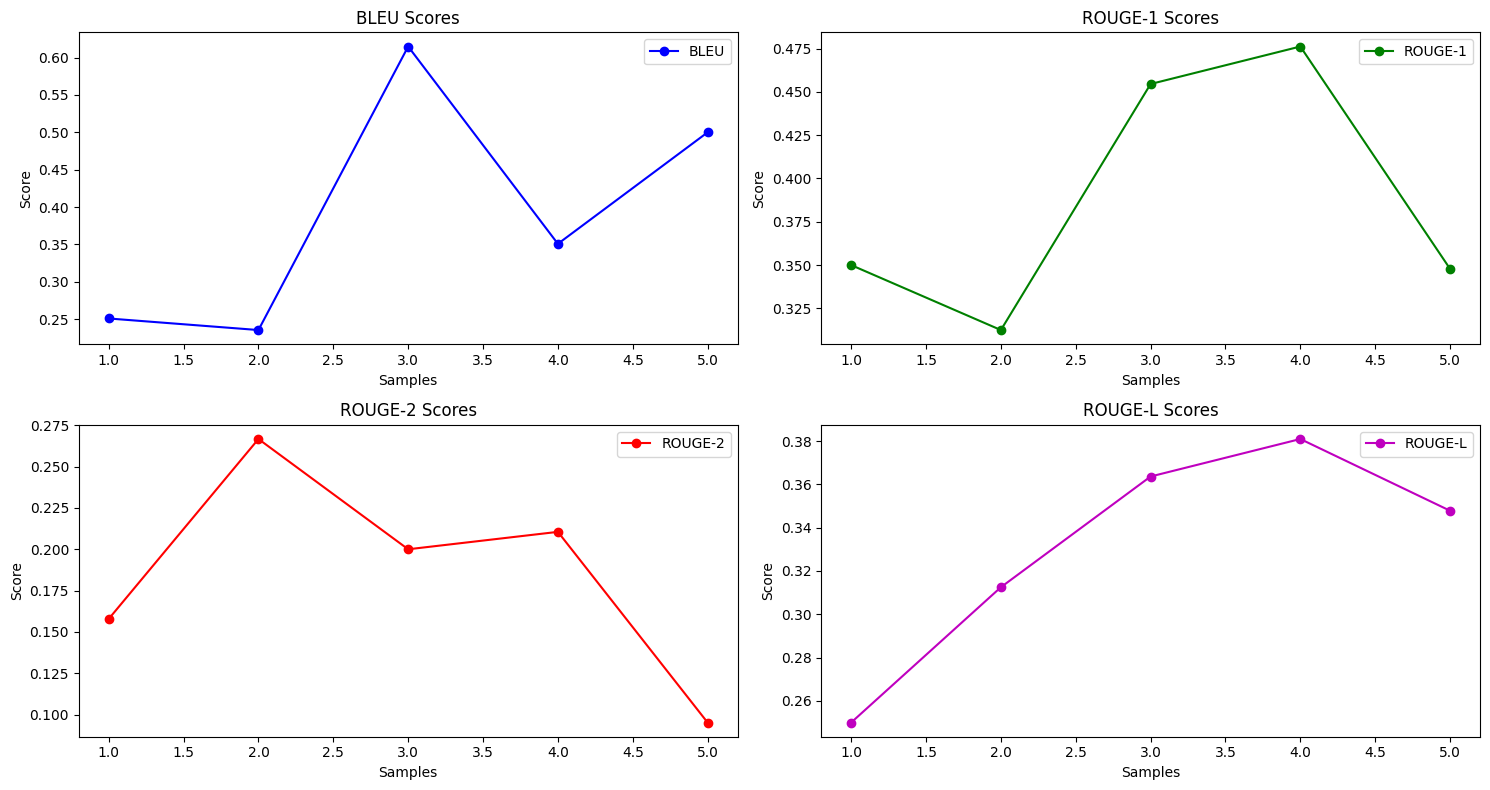

In [76]:
# Extract ROUGE metrics for each instance
rouge1_scores = [entry['rouge1'].fmeasure for entry in rouge_scores]
rouge2_scores = [entry['rouge2'].fmeasure for entry in rouge_scores]
rougeL_scores = [entry['rougeL'].fmeasure for entry in rouge_scores]

# Plot BLEU and ROUGE Scores in Separate Subplots
plt.figure(figsize=(15, 8))

# Plot BLEU Scores
plt.subplot(2, 2, 1)
plt.plot(range(1, num_samples + 1), bleu_scores, marker='o', linestyle='-', color='b', label='BLEU')
plt.title("BLEU Scores")
plt.xlabel("Samples")
plt.ylabel("Score")
plt.legend()

# Plot ROUGE-1 Scores
plt.subplot(2, 2, 2)
plt.plot(range(1, num_samples + 1), rouge1_scores, marker='o', linestyle='-', color='g', label='ROUGE-1')
plt.title("ROUGE-1 Scores")
plt.xlabel("Samples")
plt.ylabel("Score")
plt.legend()

# Plot ROUGE-2 Scores
plt.subplot(2, 2, 3)
plt.plot(range(1, num_samples + 1), rouge2_scores, marker='o', linestyle='-', color='r', label='ROUGE-2')
plt.title("ROUGE-2 Scores")
plt.xlabel("Samples")
plt.ylabel("Score")
plt.legend()

# Plot ROUGE-L Scores
plt.subplot(2, 2, 4)
plt.plot(range(1, num_samples + 1), rougeL_scores, marker='o', linestyle='-', color='m', label='ROUGE-L')
plt.title("ROUGE-L Scores")
plt.xlabel("Samples")
plt.ylabel("Score")
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()